# Two Moons Diffusion

First we start by generating a two moons distribution and visualizing it using matplotlib.

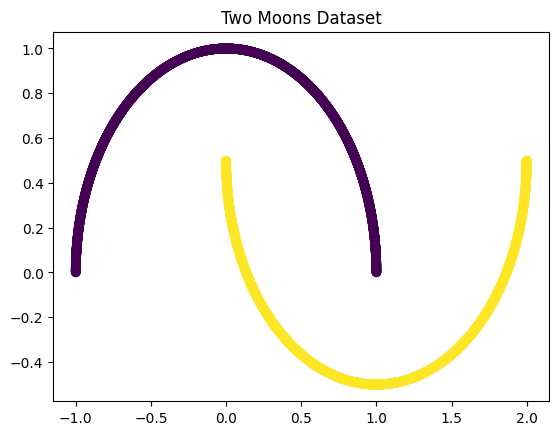

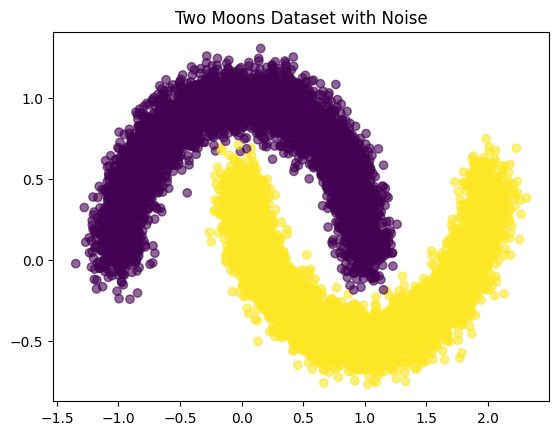

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np


def visualize_moons(dataset, title="Two Moons Dataset"):
    coords, labels = dataset
    plt.scatter(coords[:, 0], coords[:, 1], c=labels, alpha=0.6)
    plt.title(title)
    plt.show()


random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.set_default_device("cuda")

moons_dataset_unnoised = make_moons(n_samples=10000, random_state=random_seed)
visualize_moons(moons_dataset_unnoised)

moons_dataset_noised = make_moons(n_samples=10000, noise=0.1, random_state=random_seed)
visualize_moons(moons_dataset_noised, title="Two Moons Dataset with Noise")

We implement diffusion with DDPM formulation and DDIM sampling that is a deterministic Euler method.

For the noise predictor network we use a very simple architecture, consisting of a time embedder and a small MLP to predict the noise from the samples and the time embedding.  We can improve the architecture later if needed.

In [57]:
import torch
import torch.nn as nn


class NoisePredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, time_embed_dim=32):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.net = nn.Sequential(
            nn.Linear(input_dim + time_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, t):
        t_embed = self.time_embed(t)
        x = torch.cat([x, t_embed], dim=-1)
        return self.net(x)

In [3]:
import torch.nn.functional as F
from tqdm.auto import tqdm


class DiffusionModel:
    def __init__(
        self, model, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"
    ):
        self.num_timesteps = num_timesteps
        self.device = device
        self.model = model.to(device)

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)

    def ddim_sample_step(self, x_t, t, t_prev):
        predicted_noise = self.model(x_t, t.float().unsqueeze(-1))

        alpha_cumprod_t = self.alpha_cumprod[t].reshape(-1, 1)
        alpha_cumprod_t_prev = (
            self.alpha_cumprod[t_prev].reshape(-1, 1)
            if t_prev >= 0
            else torch.ones_like(alpha_cumprod_t)
        )

        sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod_t)
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1.0 - alpha_cumprod_t)
        pred_x0 = (
            x_t - sqrt_one_minus_alpha_cumprod_t * predicted_noise
        ) / sqrt_alpha_cumprod_t

        sqrt_alpha_cumprod_t_prev = torch.sqrt(alpha_cumprod_t_prev)
        sqrt_one_minus_alpha_cumprod_t_prev = torch.sqrt(1.0 - alpha_cumprod_t_prev)

        dir_xt = sqrt_one_minus_alpha_cumprod_t_prev * predicted_noise

        x_prev = sqrt_alpha_cumprod_t_prev * pred_x0 + dir_xt

        return x_prev

    def sample(self, num_samples, num_inference_steps=50, shape=(2,)):
        self.model.eval()

        step_size = self.num_timesteps // num_inference_steps
        timesteps = torch.arange(0, self.num_timesteps, step_size).long()
        timesteps = torch.cat([timesteps, torch.tensor([self.num_timesteps - 1])])
        timesteps = torch.flip(timesteps, [0])

        x = torch.randn(num_samples, *shape).to(self.device)

        for i, t in enumerate(tqdm(timesteps[:-1], desc="Sampling")):
            t_prev = timesteps[i + 1] if i < len(timesteps) - 2 else -1

            t_batch = torch.full((num_samples,), t, dtype=torch.long).to(self.device)

            with torch.no_grad():
                x = self.ddim_sample_step(x, t_batch, t_prev)

        return x

    def q_sample(self, x0, t, noise=None):
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[t].reshape(-1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[t].reshape(
            -1, 1
        )

        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

    def train_step(self, x0):
        batch_size = x0.shape[0]

        t = torch.randint(0, self.num_timesteps, (batch_size,)).to(self.device)
        noise = torch.randn_like(x0)

        x_t, _ = self.q_sample(x0, t, noise)

        predicted_noise = self.model(x_t, t.float().unsqueeze(-1))

        loss = F.mse_loss(predicted_noise, noise)

        return loss

Here is the trainer class used to train our diffusion model.

In [78]:
class Trainer:
    def __init__(
        self,
        model,
        device="cuda",
        num_epochs=10,
        batch_size=64,
        num_batches_per_epoch=10,
        learning_rate=1e-4,
        num_train_samples=20_000,
    ):
        self.device = device
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch
        self.learning_rate = learning_rate
        self.num_train_samples = num_train_samples

        self.diffusion = DiffusionModel(model, device=device)
        self.optimizer = torch.optim.Adam(
            self.diffusion.model.parameters(), lr=learning_rate
        )

        self.train_dataset = torch.tensor(
            make_moons(n_samples=num_train_samples, noise=0.1, random_state=42)[0],
            dtype=torch.float32,
        )

    def prepare_batch(self):
        indices = torch.randperm(len(self.train_dataset))[: self.batch_size]
        batch = self.train_dataset[indices].to(self.device)

        return batch

    def train(self):
        self.diffusion.model.train()

        losses = []

        for _ in tqdm(range(self.num_epochs), desc="Training"):
            for _ in range(self.num_batches_per_epoch):
                batch = self.prepare_batch()

                self.optimizer.zero_grad()

                loss = self.diffusion.train_step(batch)
                loss.backward()
                self.optimizer.step()

            losses.append(loss.item())

        return losses

    def make_loss_curve(self, losses):
        plt.plot(losses)
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.grid()
        plt.show()

Now let's train our first model for 500 epochs and see what the results look like.

Training:   0%|          | 0/500 [00:00<?, ?it/s]

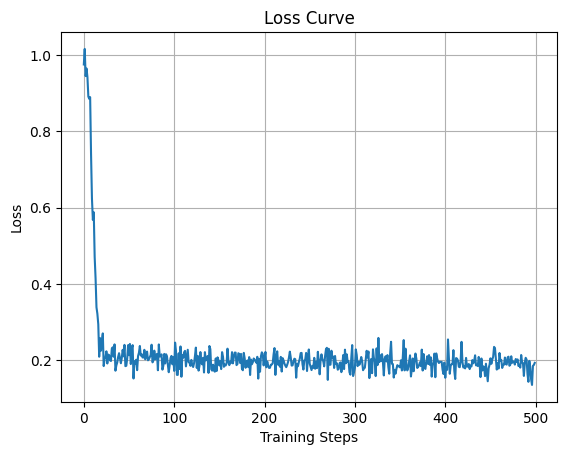

In [5]:
trainer = Trainer(
    model=NoisePredictor(),
    num_epochs=500,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
losses = trainer.train()
trainer.make_loss_curve(losses)

In [6]:
class Evaluator:
    def __init__(self, trainer, num_samples=100):
        self.trainer = trainer
        self.diffusion = trainer.diffusion

        self.num_samples = num_samples

    def eval(self):
        with torch.no_grad():
            samples = self.diffusion.sample(self.num_samples).cpu()

        self._visualize(samples)

    def _visualize(self, samples):
        gt = self.trainer.train_dataset.clone().cpu()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Generated Samples")
        plt.scatter(samples[:, 0], samples[:, 1], s=5)
        plt.axis("equal")

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth")
        plt.scatter(gt[:, 0], gt[:, 1], s=5)
        plt.axis("equal")

        plt.show()

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

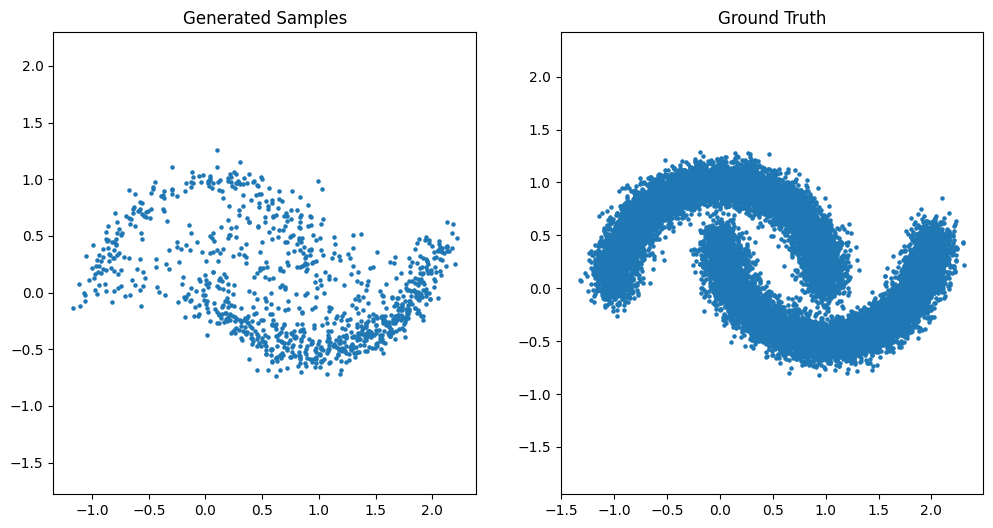

In [7]:
ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Results look pretty good for a start!

Now let's see if we get better results by training for longer...

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

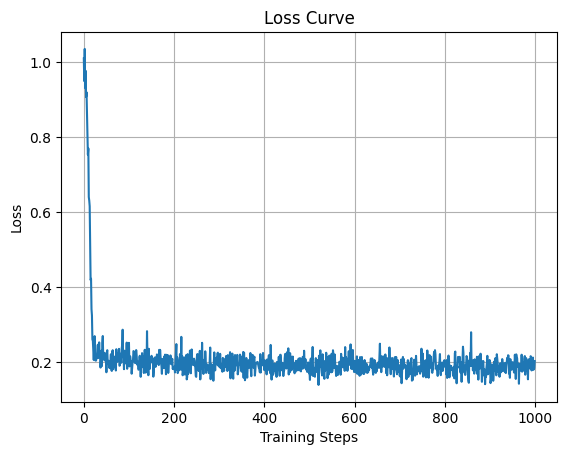

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

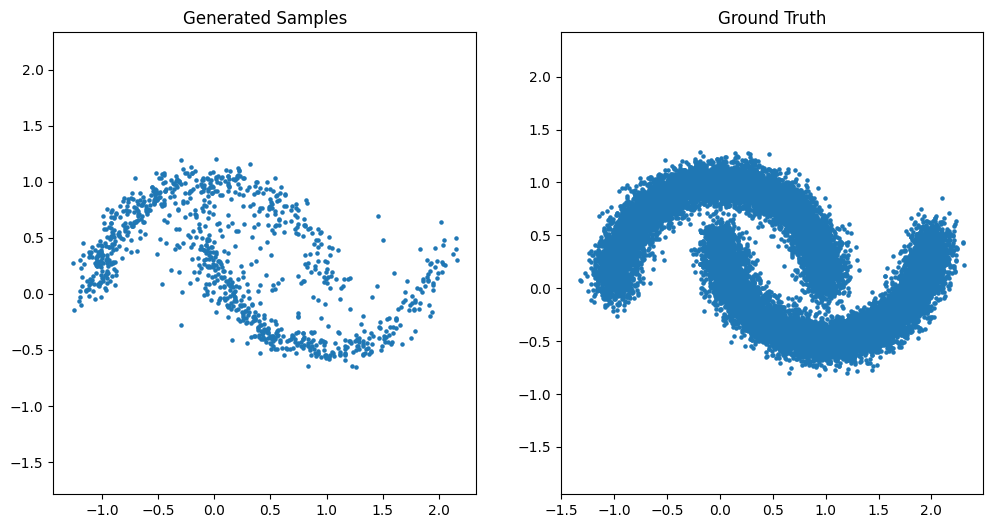

In [ ]:
trainer = Trainer(
    model=NoisePredictor(),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
losses = trainer.train()
trainer.make_loss_curve(losses)

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Results are getting better, let's try to train even longer.

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

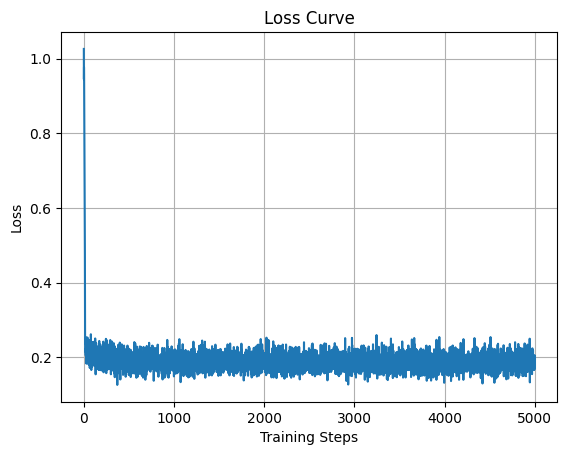

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

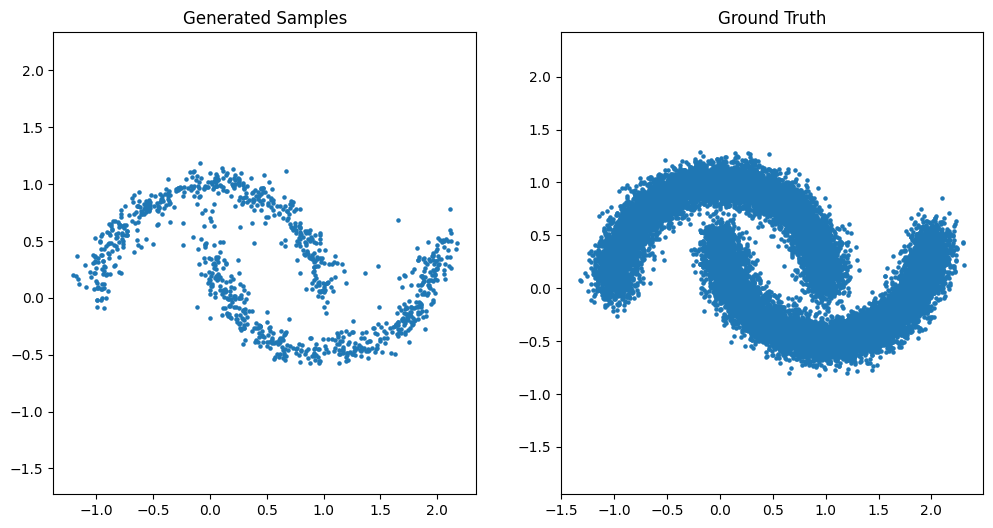

In [10]:
trainer = Trainer(
    model=NoisePredictor(),
    num_epochs=5_000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
losses = trainer.train()
trainer.make_loss_curve(losses)

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Great! Now it's time to define some metrics.

The first metric we define is based on the distance of the generated samples to the real samples.  We use the kNN algorithm to find the nearest sample to each of the generated samples.  We select a cut-off radius of 0.02 and calculate how many of the generated samples fall within that radius of the real samples.  The higher this number the closer the distribution of generated samples should be to the two moons dataset.

In [ ]:
from sklearn.neighbors import NearestNeighbors


class Evaluator:
    def __init__(self, trainer, num_samples=100):
        self.trainer = trainer
        self.diffusion = trainer.diffusion

        self.num_samples = num_samples

    def eval(self):
        with torch.no_grad():
            samples = self.diffusion.sample(self.num_samples).cpu()

        self._visualize(samples)

        distance_metric = self.calculate_distance_metric(samples)
        print(f"Distance Metric: {distance_metric}")

    def calculate_distance_metric(self, generated_samples, radius=0.02):
        real_samples = trainer.train_dataset[: len(generated_samples)].clone().cpu()

        nn = NearestNeighbors(n_neighbors=1).fit(real_samples.numpy())
        distances, _ = nn.kneighbors(generated_samples.numpy())

        return (distances.flatten() < radius).astype(int).sum() / len(generated_samples)

    def _visualize(self, samples):
        gt = self.trainer.train_dataset.clone().cpu()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Generated Samples")
        plt.scatter(samples[:, 0], samples[:, 1], s=5)
        plt.axis("equal")

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth")
        plt.scatter(gt[:, 0], gt[:, 1], s=5)
        plt.axis("equal")

        plt.show()

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

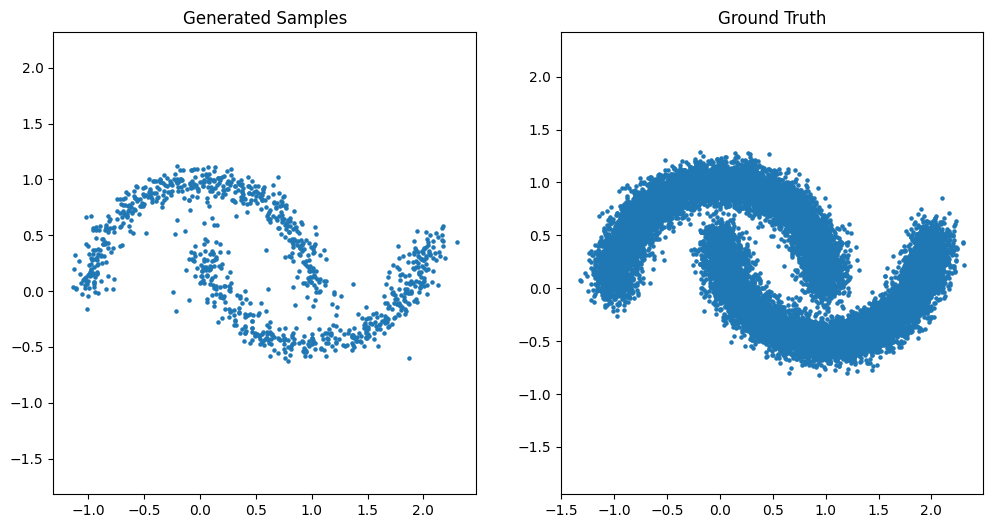

Distance Metric: 0.442


In [34]:
ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Another metric could be an MSE between the generated and real samples.  We can't use an MSE directly because the order of the samples would matter, so instead we convert the real and generated samples into a normalized histogram, and calculate the MSE between the histograms.

Since with MSE lower values is better, we also reverse the distance metric so that we'd want to minimize both.

In [44]:
class Evaluator:
    def __init__(self, trainer, num_samples=100):
        self.trainer = trainer
        self.diffusion = trainer.diffusion

        self.num_samples = num_samples

    def eval(self):
        with torch.no_grad():
            samples = self.diffusion.sample(self.num_samples).cpu()

        self._visualize(samples)

        metrics = self.calculate_metrics(samples)
        print(f"Distance: {metrics['distance']:.4f}")
        print(f"MSE: {metrics['mse']:.4f}")

    def calculate_metrics(self, generated_samples):
        real_samples = trainer.train_dataset[: len(generated_samples)].clone().cpu()

        return {
            "distance": self.calculate_distance_metric(generated_samples, real_samples),
            "mse": self.calculate_mse_metric(generated_samples, real_samples),
        }

    def calculate_mse_metric(self, generated_samples, real_samples):
        all_samples = np.vstack([real_samples.numpy(), generated_samples.numpy()])
        x_min, x_max = all_samples[:, 0].min() - 0.5, all_samples[:, 0].max() + 0.5
        y_min, y_max = all_samples[:, 1].min() - 0.5, all_samples[:, 1].max() + 0.5
        bounds = [[x_min, x_max], [y_min, y_max]]

        real_hist, _, _ = np.histogram2d(
            real_samples[:, 0], real_samples[:, 1], bins=64, range=bounds
        )
        gen_hist, _, _ = np.histogram2d(
            generated_samples[:, 0], generated_samples[:, 1], bins=64, range=bounds
        )

        real_hist = real_hist / real_hist.max() if real_hist.max() > 0 else real_hist
        gen_hist = gen_hist / gen_hist.max() if gen_hist.max() > 0 else gen_hist

        return np.mean((real_hist - gen_hist) ** 2)

    def calculate_distance_metric(self, generated_samples, real_samples, radius=0.02):
        nn = NearestNeighbors(n_neighbors=1).fit(real_samples.numpy())
        distances, _ = nn.kneighbors(generated_samples.numpy())

        return 1.0 - (distances.flatten() < radius).astype(int).sum() / len(
            generated_samples
        )

    def _visualize(self, samples):
        gt = self.trainer.train_dataset.clone().cpu()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Generated Samples")
        plt.scatter(samples[:, 0], samples[:, 1], s=5)
        plt.axis("equal")

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth")
        plt.scatter(gt[:, 0], gt[:, 1], s=5)
        plt.axis("equal")

        plt.show()

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

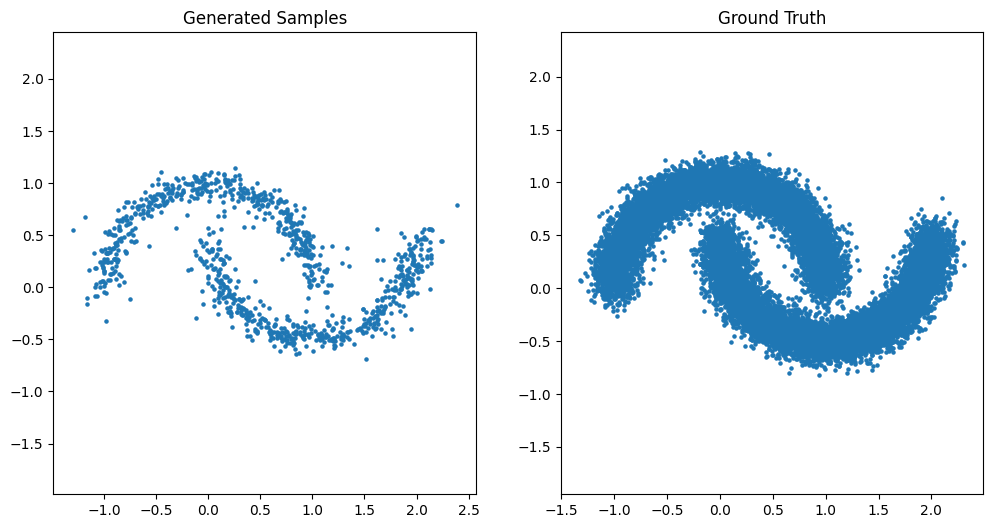

Distance: 0.5410
MSE: 0.0111


In [45]:
ev = Evaluator(trainer, num_samples=1000)
ev.eval()

One thing that these metrics don't quite measure yet is the visual shape, we want the generated samples to form two separated clusters.  The clustering itself is easy, we can use kMeans clustering and ensure we get two clusters.  In order to ensure the clusters are separate I found the silhouette score as a metric (there may be better ways of measuring that but this seems to get the job done.)  Again we make sure that this metric is a number we want to minimize.  Now we can also calculate an overall metric based on these three.

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


class Evaluator:
    def __init__(self, trainer, num_samples=100):
        self.trainer = trainer
        self.diffusion = trainer.diffusion

        self.num_samples = num_samples

    def eval(self):
        with torch.no_grad():
            samples = self.diffusion.sample(self.num_samples).cpu()

        self._visualize(samples)

        metrics = self.calculate_metrics(samples)
        print(f"Distance: {metrics['distance']:.4f}")
        print(f"MSE: {metrics['mse']:.4f}")
        print(f"Shape: {metrics['shape']:.4f}")

        print(f"Overall: {(metrics['distance'] + metrics['mse'] + metrics['shape']) / 3.0:.4f}")

    def calculate_metrics(self, generated_samples):
        real_samples = trainer.train_dataset[: len(generated_samples)].clone().cpu().numpy()
        generated_samples = generated_samples.numpy()

        return {
            "distance": self.calculate_distance_metric(generated_samples, real_samples),
            "mse": self.calculate_mse_metric(generated_samples, real_samples),
            "shape": self.calculate_shape_metric(generated_samples, real_samples),
        }

    def calculate_shape_metric(self, generated_samples, real_samples):
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = kmeans.fit_predict(generated_samples)

        unique_labels = np.unique(labels)
        if len(unique_labels) != 2:
            return 1.0

        silhouette = silhouette_score(generated_samples, labels)
        return (1.0 - silhouette) / 2.0

    def calculate_mse_metric(self, generated_samples, real_samples):
        all_samples = np.vstack([real_samples, generated_samples])
        x_min, x_max = all_samples[:, 0].min() - 0.5, all_samples[:, 0].max() + 0.5
        y_min, y_max = all_samples[:, 1].min() - 0.5, all_samples[:, 1].max() + 0.5
        bounds = [[x_min, x_max], [y_min, y_max]]

        real_hist, _, _ = np.histogram2d(
            real_samples[:, 0], real_samples[:, 1], bins=64, range=bounds
        )
        gen_hist, _, _ = np.histogram2d(
            generated_samples[:, 0], generated_samples[:, 1], bins=64, range=bounds
        )

        real_hist = real_hist / real_hist.max() if real_hist.max() > 0 else real_hist
        gen_hist = gen_hist / gen_hist.max() if gen_hist.max() > 0 else gen_hist

        return np.mean((real_hist - gen_hist) ** 2)

    def calculate_distance_metric(self, generated_samples, real_samples, radius=0.02):
        nn = NearestNeighbors(n_neighbors=1).fit(real_samples)
        distances, _ = nn.kneighbors(generated_samples)

        return 1.0 - (distances.flatten() < radius).astype(int).sum() / len(
            generated_samples
        )

    def _visualize(self, samples):
        gt = self.trainer.train_dataset.clone().cpu()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Generated Samples")
        plt.scatter(samples[:, 0], samples[:, 1], s=5)
        plt.axis("equal")

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth")
        plt.scatter(gt[:, 0], gt[:, 1], s=5)
        plt.axis("equal")

        plt.show()

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

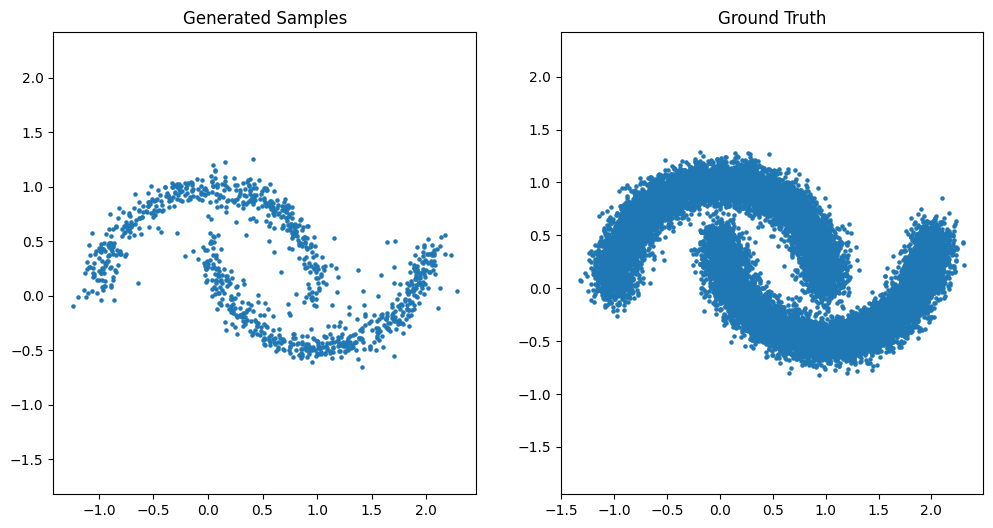

Distance: 0.5450
MSE: 0.0101
Shape: 0.2547
Overall: 0.2699


In [51]:
ev = Evaluator(trainer, num_samples=1000)
ev.eval()

OK now let's see what improvements we can make to the model to improve the metrics.  We will use the 1000 epoch training run as baseline because it is quicker to run, and at the end we'll verify that the metrics still improve if we repeat the 5000 epoch training.

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

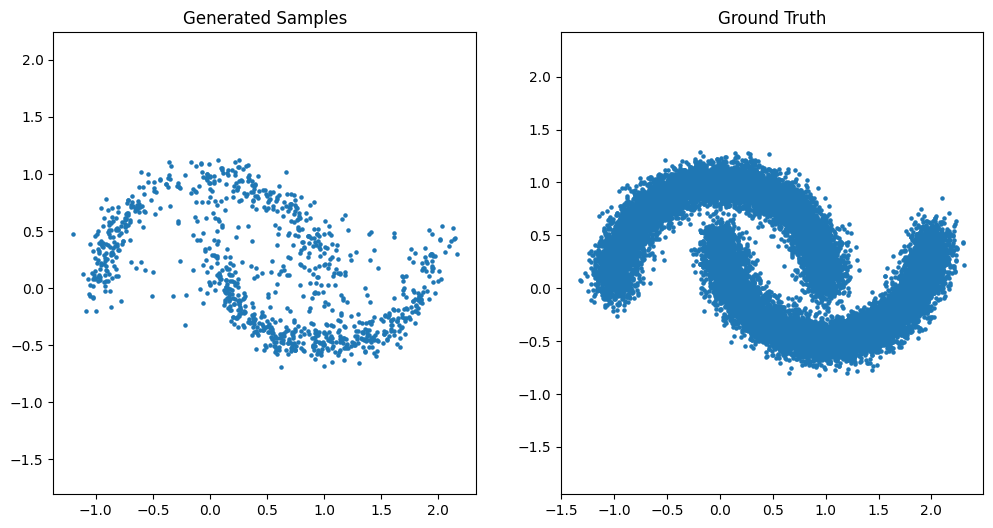

Distance: 0.5920
MSE: 0.0096
Shape: 0.2635
Overall: 0.2884


In [54]:
# baseline

trainer = Trainer(
    model=NoisePredictor(),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
trainer.train()

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

The most obvious way we can potentially improve things is to use a larger network with more layers, let's try that!

In [55]:
class LargerNoisePredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=512, time_embed_dim=64):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.net = nn.Sequential(
            nn.Linear(input_dim + time_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, t):
        t_embed = self.time_embed(t)
        x = torch.cat([x, t_embed], dim=-1)
        return self.net(x)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

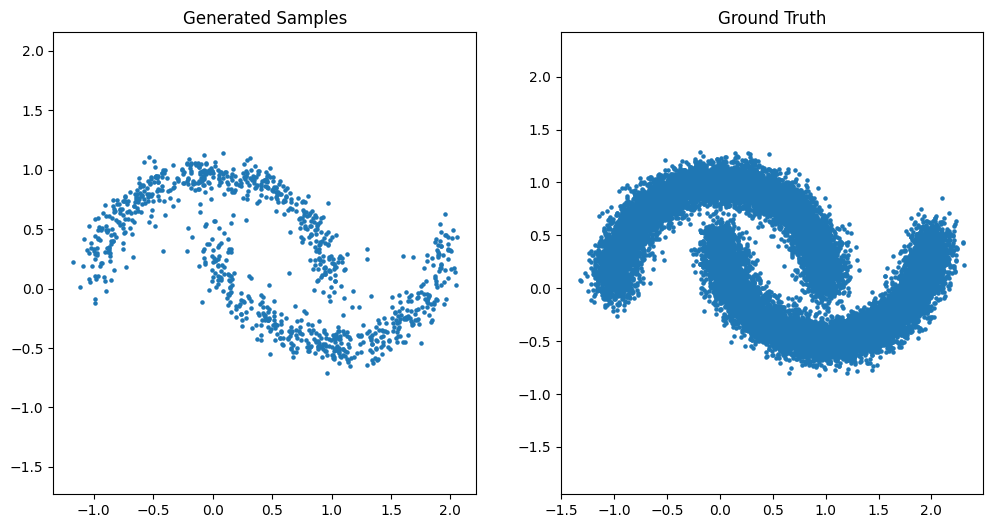

Distance: 0.5770
MSE: 0.0097
Shape: 0.2382
Overall: 0.2750


In [56]:
trainer = Trainer(
    model=LargerNoisePredictor(),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
trainer.train()

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

This seems to work! The distance and shape metrics decreased and MSE stayed about the same.  But also visually it's clear the model has improved a lot.  Let's go even bigger!

In [60]:
class EvenLargerNoisePredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=1024, time_embed_dim=128, num_layers=8, num_layers_time_embed=4):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        time_embed_layers = [
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
        ]
        for _ in range(num_layers_time_embed - 1):
            time_embed_layers.extend([
                nn.Linear(time_embed_dim, time_embed_dim),
                nn.ReLU(),
            ])

        self.time_embed = nn.Sequential(*time_embed_layers)

        layers = [nn.Linear(input_dim + time_embed_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 2):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, input_dim))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        t_embed = self.time_embed(t)
        x = torch.cat([x, t_embed], dim=-1)
        return self.net(x)


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

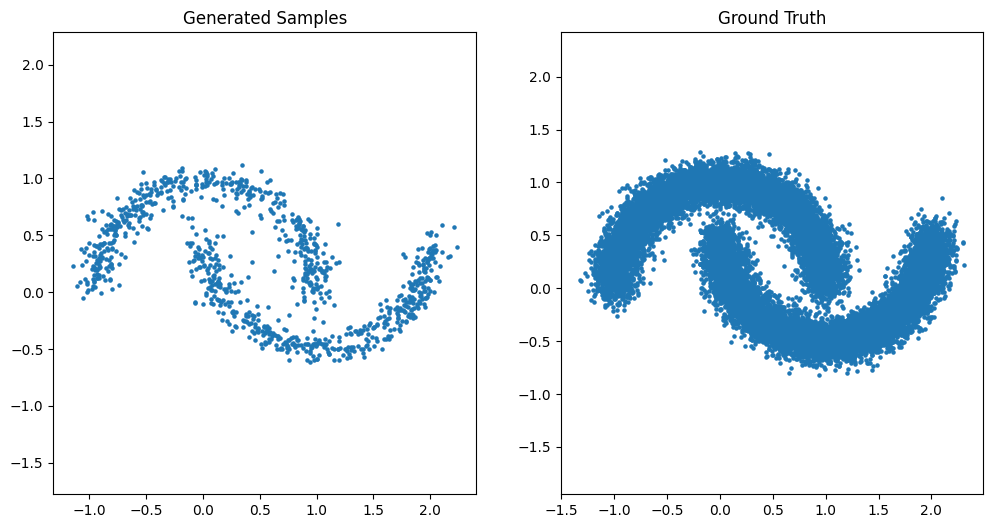

Distance: 0.5480
MSE: 0.0103
Shape: 0.2416
Overall: 0.2666


In [61]:
trainer = Trainer(
    model=EvenLargerNoisePredictor(),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
trainer.train()

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Going even larger decreases the distance metric but regresses the shape and MSE metrics, and the visual results have not improved that much, so perhaps it's asymptoting.  How about a different approach, by adding residual connections?  Let's try that.

In [85]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(x + self.net(x))

class ResidualNoisePredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=512, time_embed_dim=64, num_res_blocks=5, num_layers_time_embed=2):
        super().__init__()
        
        time_embed_layers = [
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
        ]
        for _ in range(num_layers_time_embed - 1):
            time_embed_layers.extend([
                nn.Linear(time_embed_dim, time_embed_dim),
                nn.ReLU(),
            ])

        self.time_embed = nn.Sequential(*time_embed_layers)
        
        self.input_proj = nn.Linear(input_dim + time_embed_dim, hidden_dim)
        
        self.res_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(num_res_blocks)
        ])
        
        self.output_proj = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x, t):
        t_embed = self.time_embed(t)
        x = torch.cat([x, t_embed], dim=-1)
        
        x = self.input_proj(x)
        for block in self.res_blocks:
            x = block(x)
        return self.output_proj(x)


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

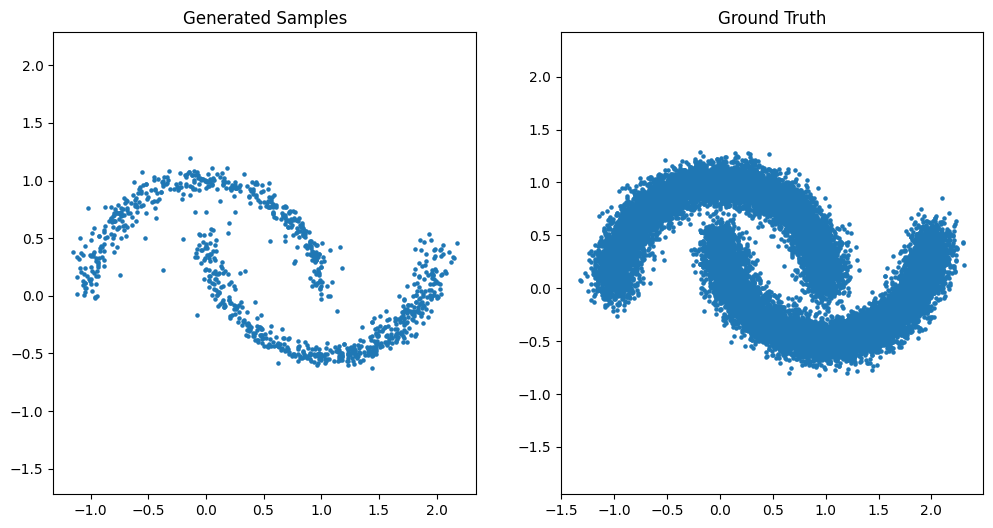

Distance: 0.5390
MSE: 0.0088
Shape: 0.2430
Overall: 0.2636


In [66]:
trainer = Trainer(
    model=ResidualNoisePredictor(),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
trainer.train()

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Compared to the `LargerNoisePredictor` network, this improves the distance and MSE metrics but regresses the shape metric.  However visually the results actually look a lot better, so I think the residual connections are helping more than blindly increasing the size of the network.  With that in mind, I think it's prudent to try a mini-UNet structure to see if the architecture would also benefit from the multi-scale encoder/decoder structure of the UNet, in addition to the skip connections.

In [67]:
class MiniUnetNoisePredictor(nn.Module):
    def __init__(self, input_dim=2, base_dim=512, time_embed_dim=64, num_layers_time_embed=2):
        super().__init__()
        
        time_embed_layers = [
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
        ]
        for _ in range(num_layers_time_embed - 1):
            time_embed_layers.extend([
                nn.Linear(time_embed_dim, time_embed_dim),
                nn.ReLU(),
            ])

        self.time_embed = nn.Sequential(*time_embed_layers)
        
        self.down1 = nn.Sequential(
            nn.Linear(input_dim + time_embed_dim, base_dim),
            nn.ReLU(),
            nn.Linear(base_dim, base_dim),
            nn.ReLU()
        )
        
        self.down2 = nn.Sequential(
            nn.Linear(base_dim, base_dim * 2),
            nn.ReLU(),
            nn.Linear(base_dim * 2, base_dim * 2),
            nn.ReLU()
        )
        
        self.down3 = nn.Sequential(
            nn.Linear(base_dim * 2, base_dim * 4),
            nn.ReLU(),
            nn.Linear(base_dim * 4, base_dim * 4),
            nn.ReLU()
        )
        
        self.up3 = nn.Sequential(
            nn.Linear(base_dim * 4, base_dim * 2),
            nn.ReLU(),
            nn.Linear(base_dim * 2, base_dim * 2),
            nn.ReLU()
        )
        
        self.up2 = nn.Sequential(
            nn.Linear(base_dim * 4, base_dim),  # * 4 due to skip connection
            nn.ReLU(),
            nn.Linear(base_dim, base_dim),
            nn.ReLU()
        )
        
        self.up1 = nn.Sequential(
            nn.Linear(base_dim * 2, base_dim),  # * 2 due to skip connection
            nn.ReLU(),
            nn.Linear(base_dim, input_dim)
        )
    
    def forward(self, x, t):
        t_embed = self.time_embed(t)
        x = torch.cat([x, t_embed], dim=-1)
        
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        
        u3 = self.up3(d3)
        u2 = self.up2(torch.cat([u3, d2], dim=-1))
        u1 = self.up1(torch.cat([u2, d1], dim=-1))
        
        return u1


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

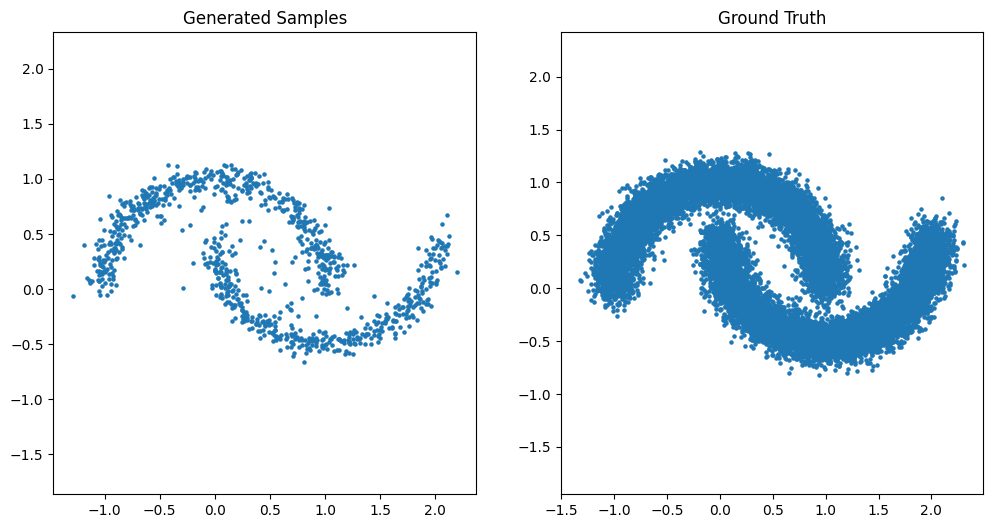

Distance: 0.5230
MSE: 0.0113
Shape: 0.2514
Overall: 0.2619


In [68]:
trainer = Trainer(
    model=MiniUnetNoisePredictor(),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
trainer.train()

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Interesting, our distance metric improves but both MSE and shape regress, and the result looks worse visually, so it looks like the mini-UNet is not helpful for this problem.  Out of curiosity we try increasing the number of resblocks in the `ResidualNoisePredictor`.

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

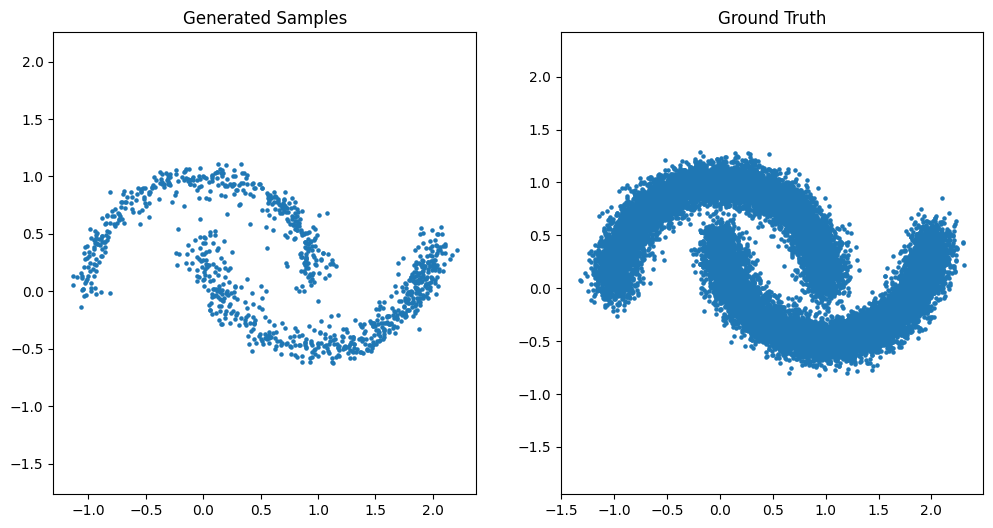

Distance: 0.5400
MSE: 0.0093
Shape: 0.2489
Overall: 0.2661


In [69]:
trainer = Trainer(
    model=ResidualNoisePredictor(num_res_blocks=8),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
trainer.train()

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

OK this also doesn't look to be helpful, neither based on metrics nor the visual comparison.

Another idea is to try sinusoidal time embeddings which usually work better for diffusion.

In [91]:
import math

class ResidualNoisePredictorWithSinusoidalTime(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=512, time_embed_dim=64, num_res_blocks=5, time_projection=False):
        super().__init__()
        
        self.time_embed_dim = time_embed_dim
        self.time_projection = time_projection
        
        if self.time_projection:
            self.time_proj = nn.Sequential(
                nn.Linear(time_embed_dim, time_embed_dim),
                nn.ReLU(),
            )
            
        self.input_proj = nn.Linear(input_dim + time_embed_dim, hidden_dim)
        
        self.res_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(num_res_blocks)
        ])
        
        self.output_proj = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def sinusoidal_time_embedding(self, t, dim):
        half_dim = dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb

    def forward(self, x, t):
        if t.dim() == 2 and t.shape[1] == 1:
            t = t.flatten()
        t_embed = self.sinusoidal_time_embedding(t, self.time_embed_dim)
        if self.time_projection:
            t_embed = self.time_proj(t_embed)
        
        x = torch.cat([x, t_embed], dim=-1)
        
        x = self.input_proj(x)
        for block in self.res_blocks:
            x = block(x)
        return self.output_proj(x)


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

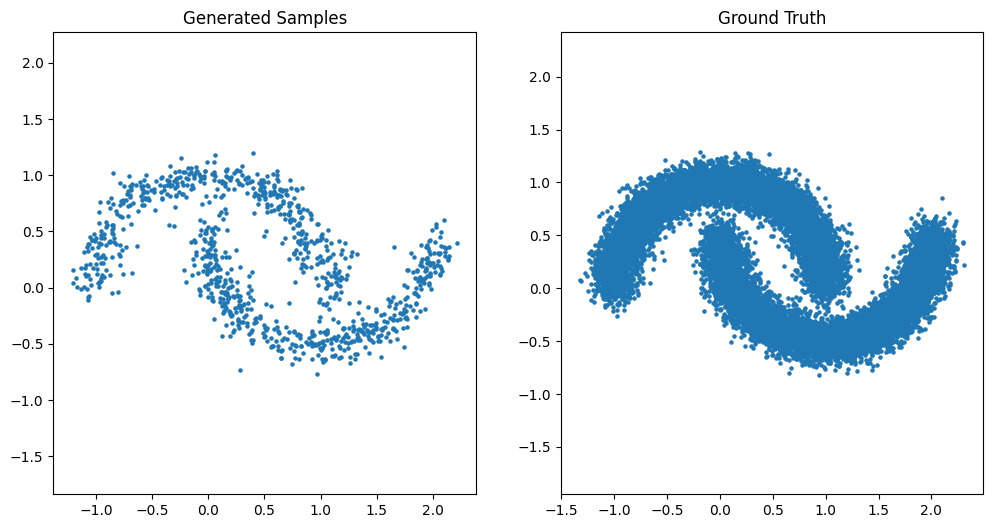

Distance: 0.5870
MSE: 0.0136
Shape: 0.2631
Overall: 0.2879


In [ ]:
trainer = Trainer(
    model=ResidualNoisePredictorWithSinusoidalTime(num_res_blocks=8),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
trainer.train()

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

OK this is also not helpful, we'll stick with `ResidualNoisePredictor` as the selected architecture.

Now that we have an architecture in place, we should also see if data augmentation would help.

In [79]:
class TrainerWithDataAugmentation(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.create_augmented_datasets()
    
    def create_augmented_datasets(self):
        original_data = make_moons(n_samples=self.num_train_samples, noise=0.1, random_state=42)[0]
        
        datasets = [original_data]
        
        # rotate
        for angle in [np.pi/4, np.pi/2, 3*np.pi/4, np.pi]:
            rotated = self.rotate_data(original_data, angle)
            datasets.append(rotated)
        
        # scaled
        for scale in [0.7, 1.3, 1.5]:
            scaled = original_data * scale
            datasets.append(scaled)
        
        # translate
        for dx, dy in [(0.5, 0), (-0.5, 0), (0, 0.5), (0, -0.5)]:
            translated = original_data + np.array([dx, dy])
            datasets.append(translated)
        
        self.augmented_train_dataset = torch.tensor(
            np.vstack(datasets), dtype=torch.float32
        )
    
    def rotate_data(self, data, angle):
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
        return data @ rotation_matrix.T

    def prepare_batch(self):
        indices = torch.randperm(len(self.augmented_train_dataset))[: self.batch_size]
        batch = self.augmented_train_dataset[indices].to(self.device)

        return batch


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

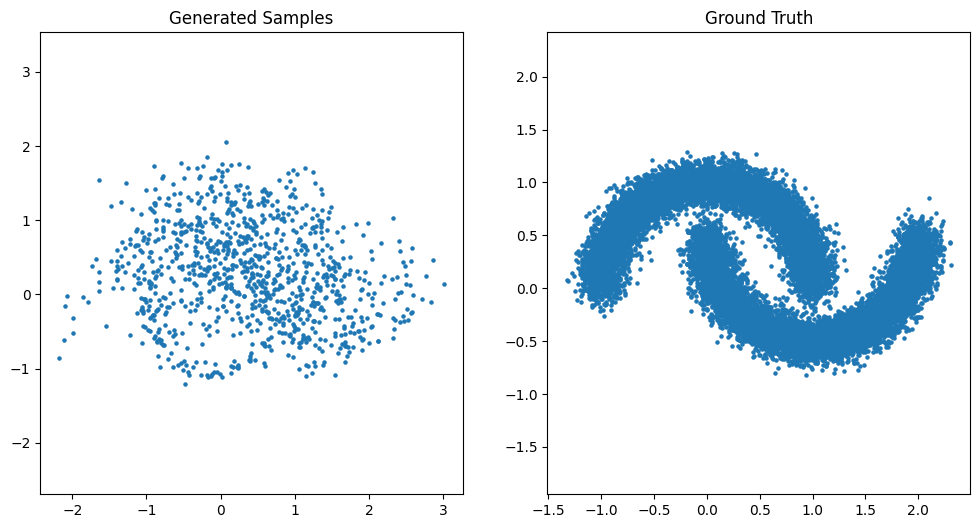

Distance: 0.8640
MSE: 0.0132
Shape: 0.2989
Overall: 0.3920


In [80]:
trainer = TrainerWithDataAugmentation(
    model=ResidualNoisePredictor(),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
trainer.train()

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Unfortunately this kind of data augmentation really hurts things, both visually as well as on the metrics.  But at least this shows that our metrics are somewhat indicative of good vs bad results!